In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from scipy.special import softmax

from tqdm import tqdm

from battleship.fast_sampler import FastSampler
from battleship.board import Board

In [61]:
# Configure Seaborn for high definition scientific plots
sns.set_context('paper')
sns.set_style('whitegrid')
sns.set_palette('colorblind')

# Configure seaborn for retina display
%config InlineBackend.figure_format = 'retina'

In [13]:
SHIP_LENGTHS = range(2, 6)
SHIP_LABELS = ["R", "G", "P", "O"]

BOARD_EMPTY = Board(np.full((8, 8), -1))
SEED = 123

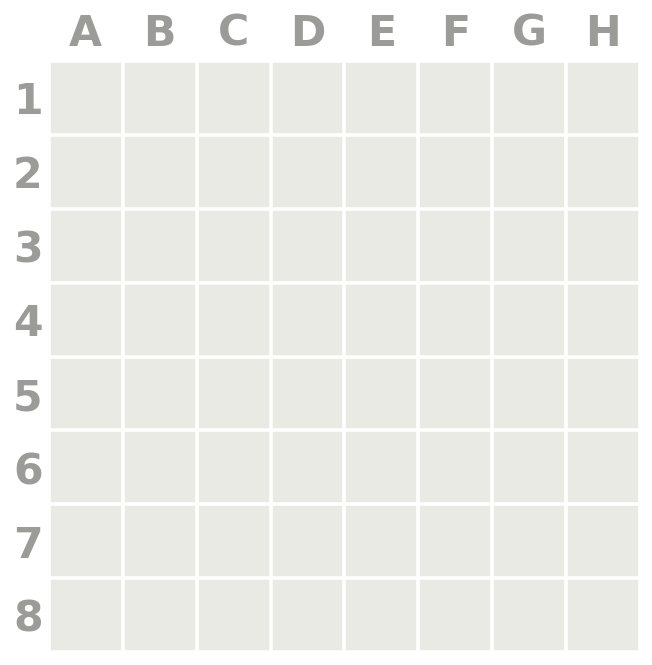

In [14]:
BOARD_EMPTY

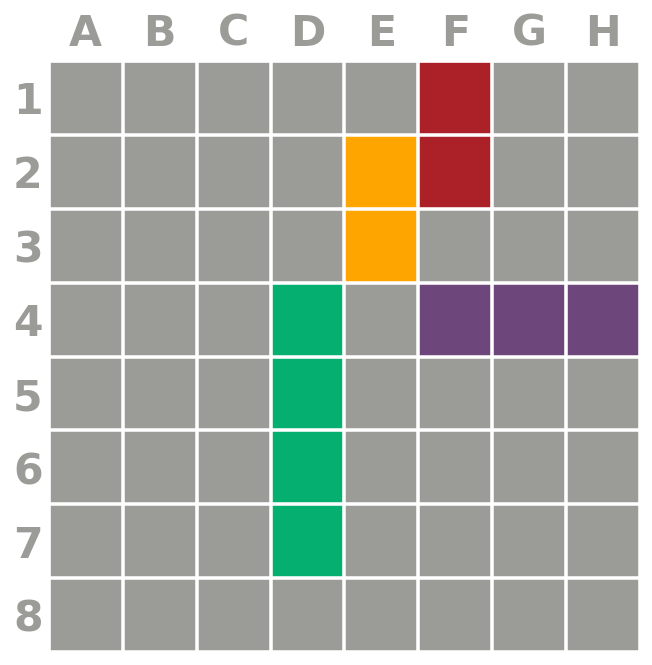

In [15]:
# Generate the target board

sampler = FastSampler(
    board=BOARD_EMPTY, ship_lengths=SHIP_LENGTHS, ship_labels=SHIP_LABELS, seed=SEED
)

BOARD_TARGET = sampler.populate_board()
BOARD_TARGET

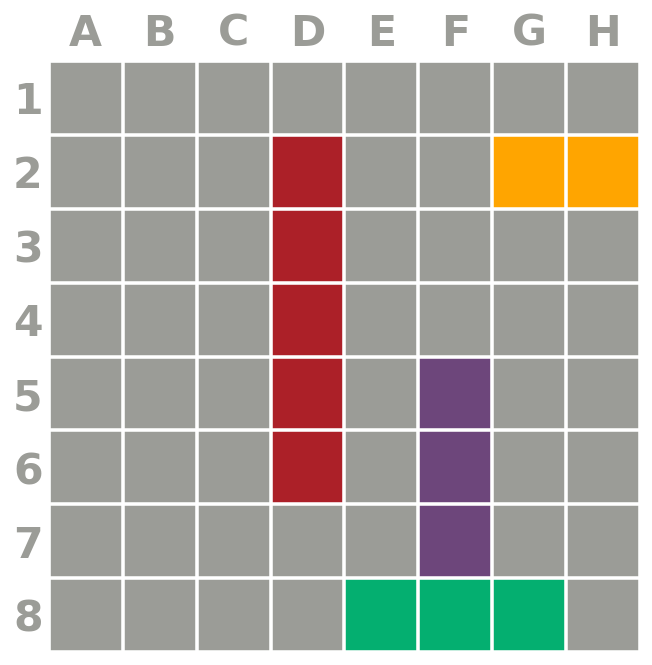

In [16]:
board_agent = Board(BOARD_EMPTY.board)

sampler = FastSampler(
    board=board_agent, ship_lengths=SHIP_LENGTHS, ship_labels=SHIP_LABELS
)
sampler.populate_board()

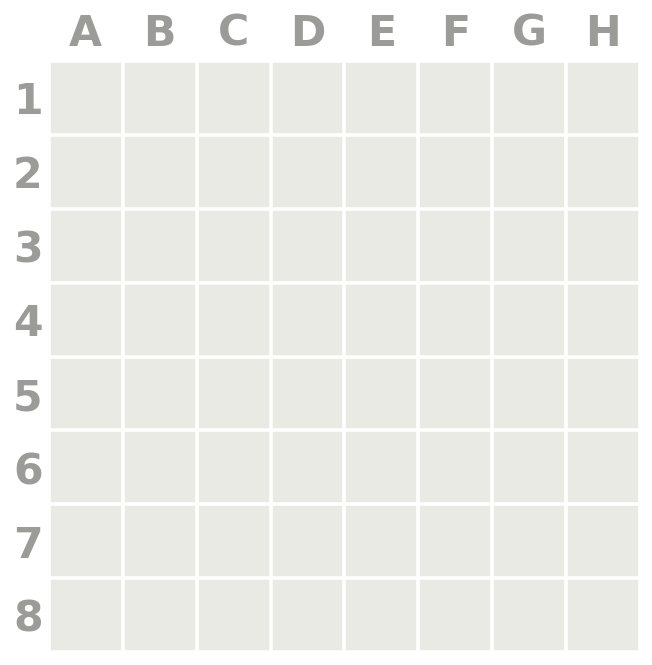

In [17]:
BOARD_EMPTY

In [32]:
# A baseline agent that computes a posterior over the visible board in order to make a move

def check_win(board_agent: Board, board_target: Board):
    """Checks whether all ship tiles have been revealed.

    Ship tiles are all tiles with a positive integer value.
    """
    return np.all(board_agent.board[board_target.board > 0] > 0)

def simulate_game(board_start: Board, board_target: Board, n_samples: int = 1000, seed: int = 123, show_board: bool = False):
    rng = np.random.default_rng(seed)

    board_agent = Board(board_start.board.copy())

    moves = []

    while not check_win(board_agent, board_target):
        # Compute the posterior over the board
        sampler = FastSampler(
            board=board_agent, ship_lengths=SHIP_LENGTHS, ship_labels=SHIP_LABELS, seed=SEED
        )

        posterior = sampler.compute_posterior(n_samples=n_samples, normalize=False)

        # Mask the posterior to only use hidden tiles
        posterior_masked = posterior * (board_agent.board == -1)

        # Apply softmax to the posterior
        posterior_masked = softmax(posterior_masked)

        # Sample a tile from the posterior
        tile_idx = rng.choice(
            np.arange(board_agent.size**2), p=posterior_masked.flatten()
        )

        # Convert the tile index back to a 2D index
        tile = np.unravel_index(tile_idx, board_agent.board.shape)

        # Reveal the sampled tile
        board_agent.board[tile] = board_target.board[tile]

        moves.append(tile)

        if show_board:
            display(board_agent)

    if show_board:
        print(f"Finished in {len(moves)} moves!")

    return moves

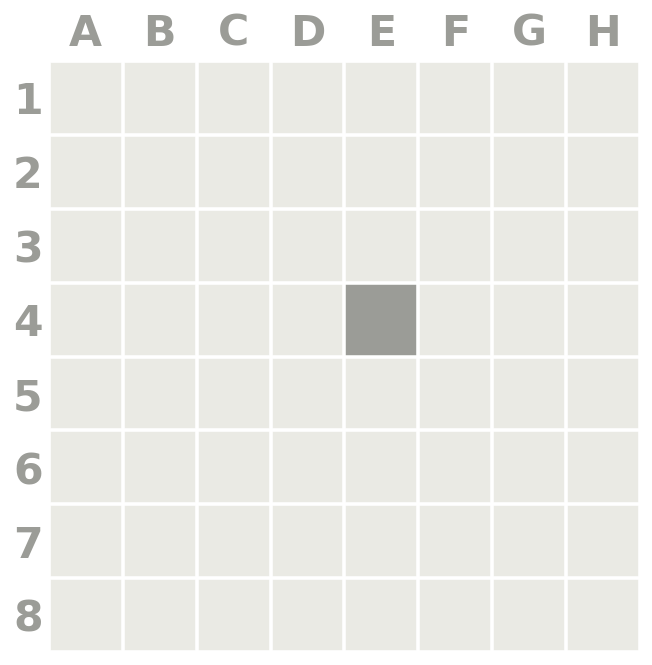

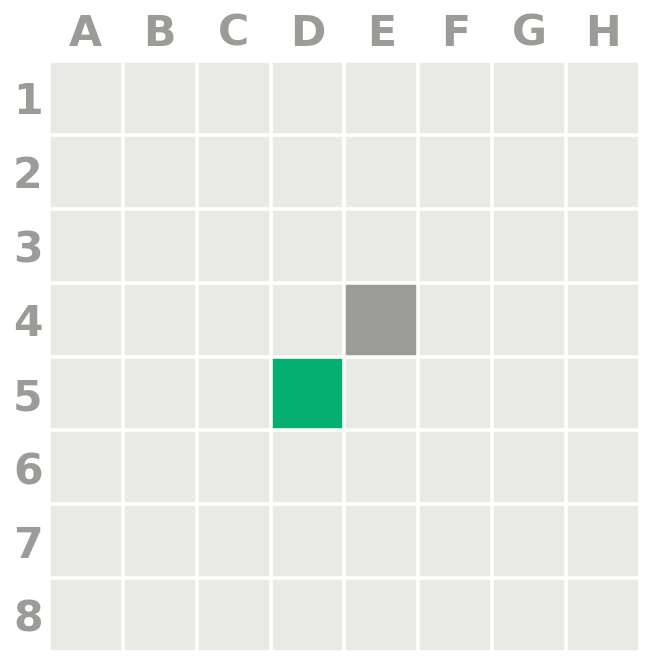

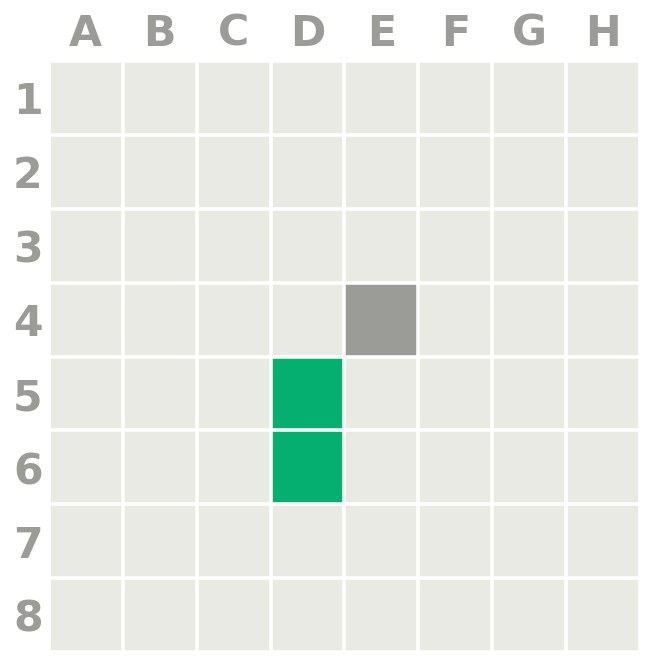

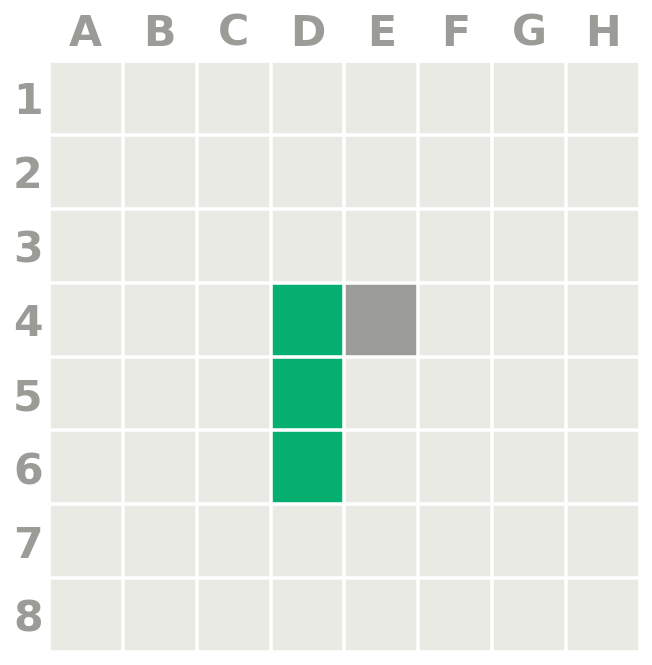

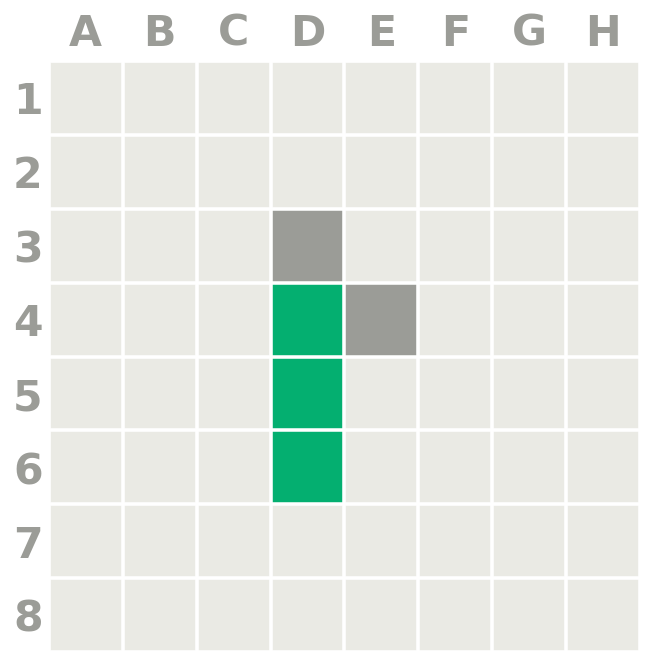

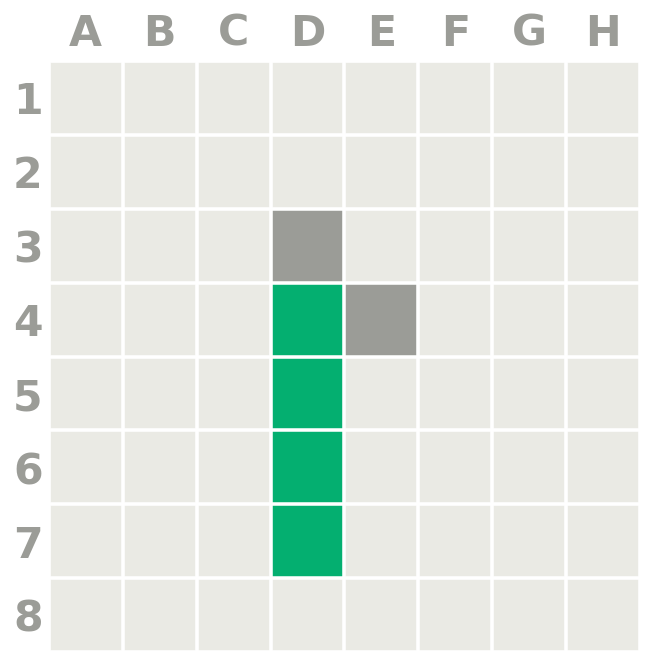

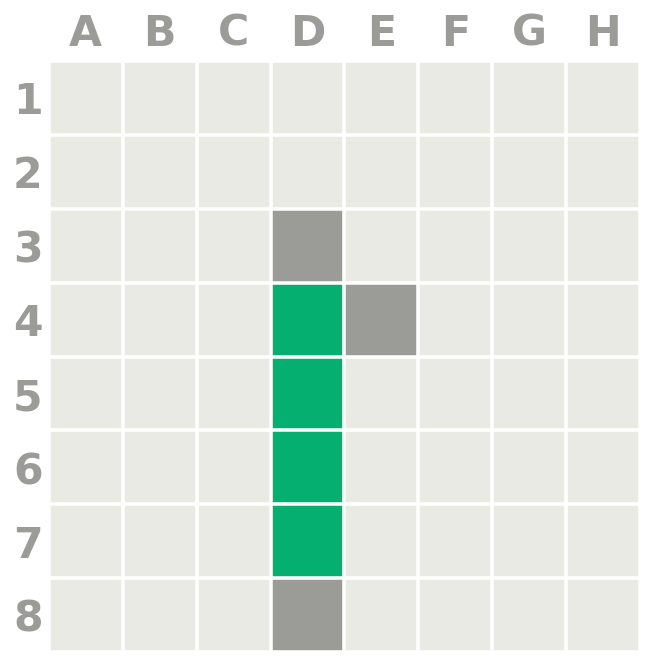

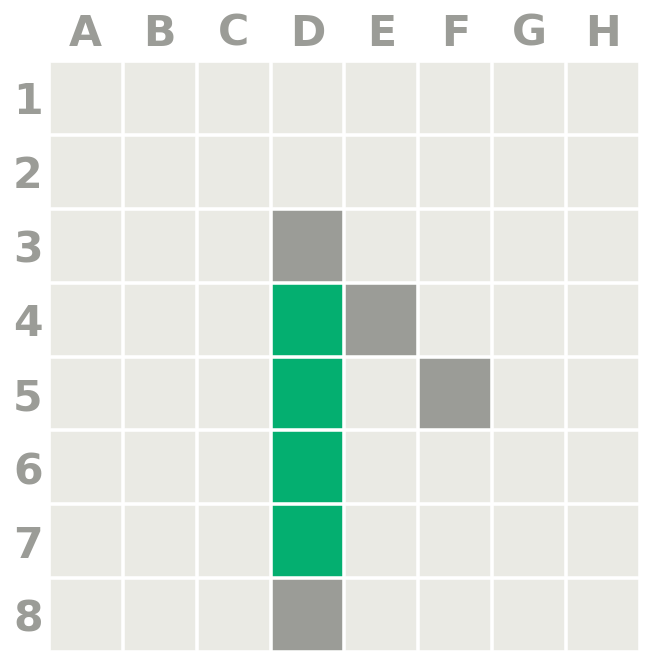

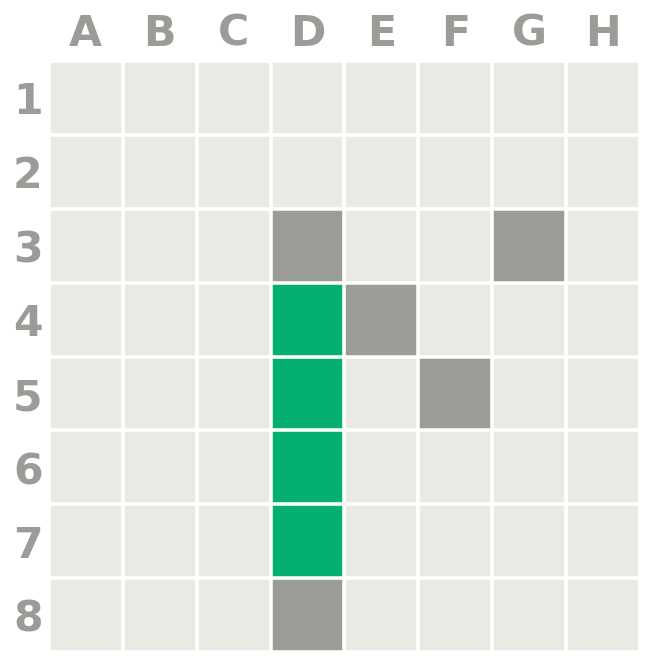

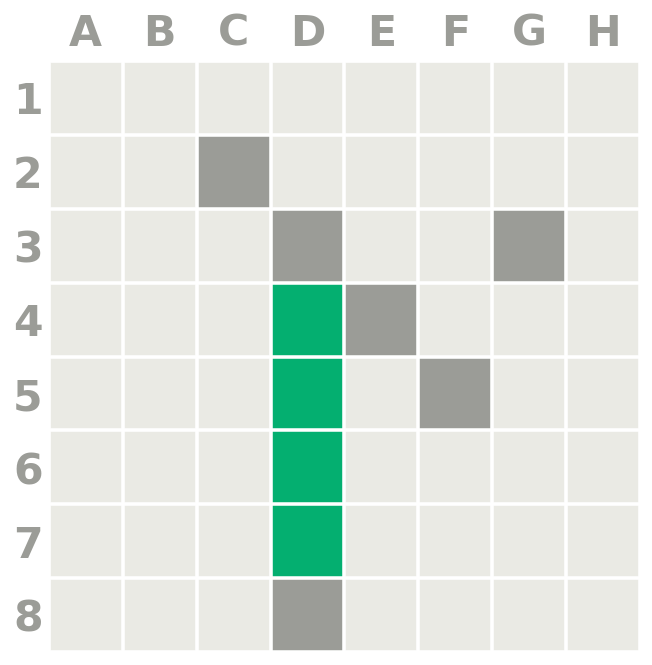

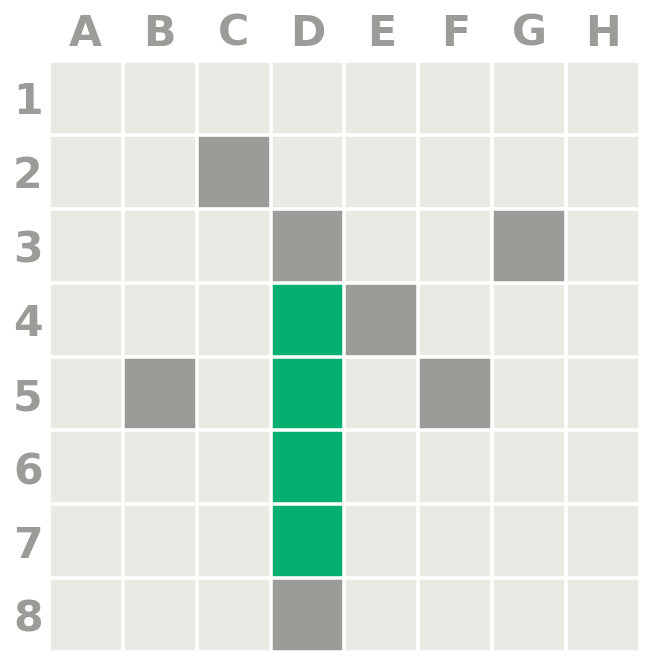

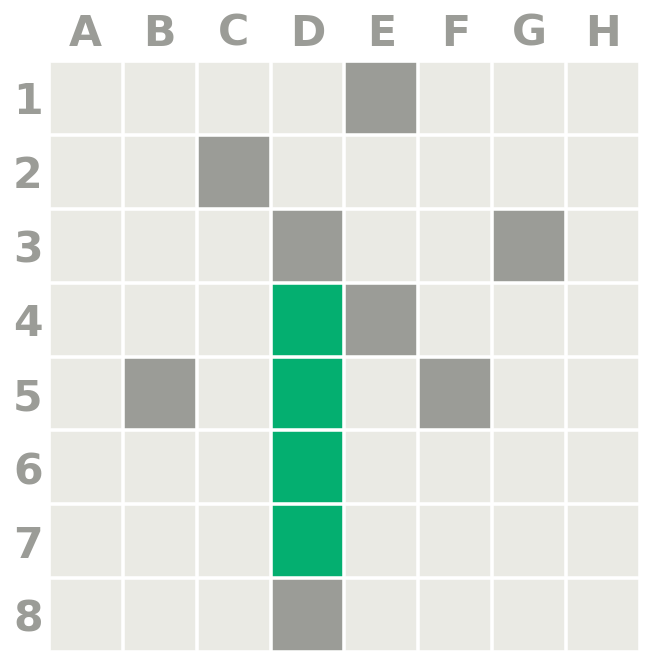

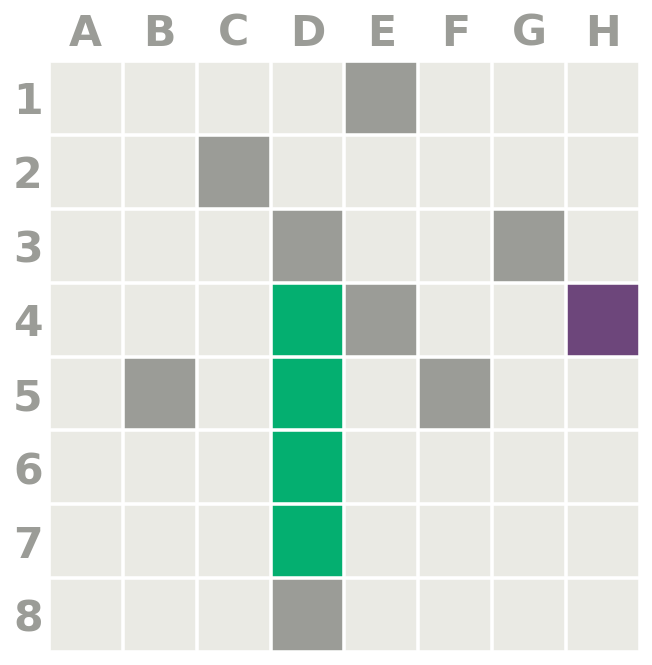

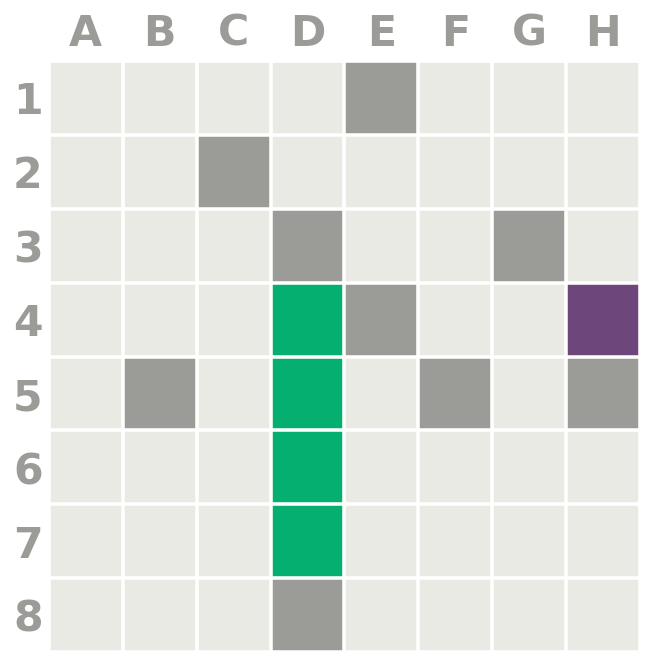

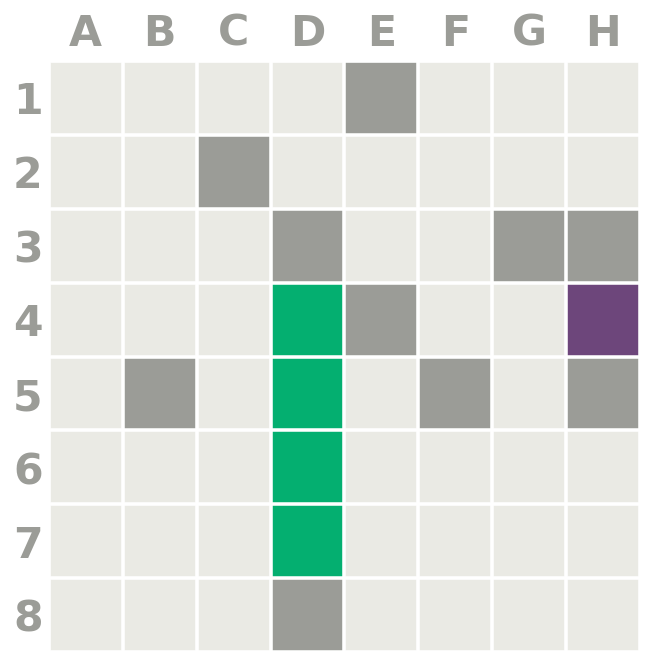

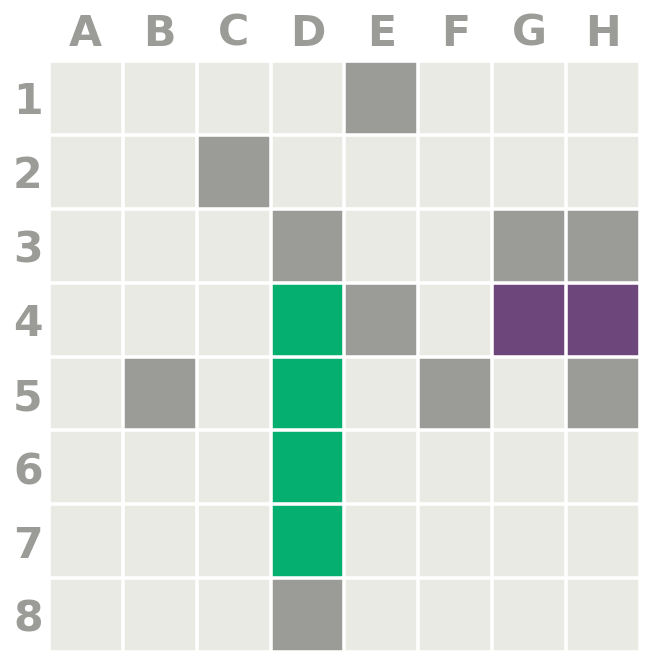

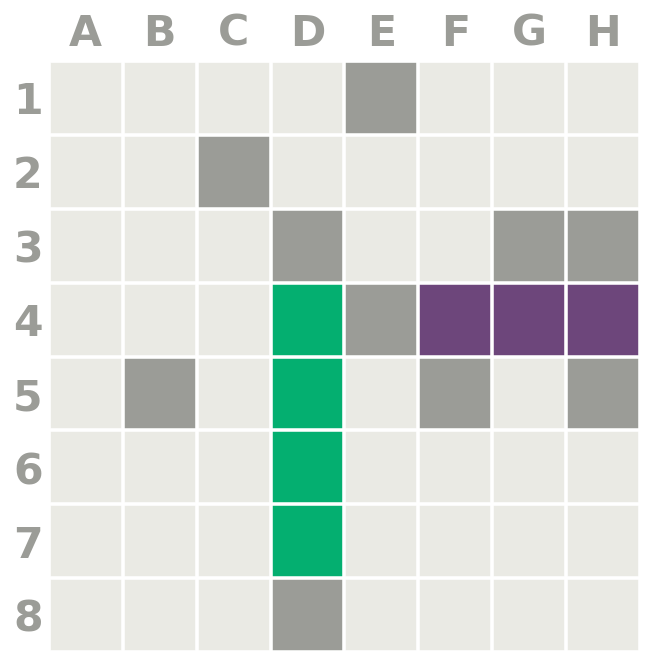

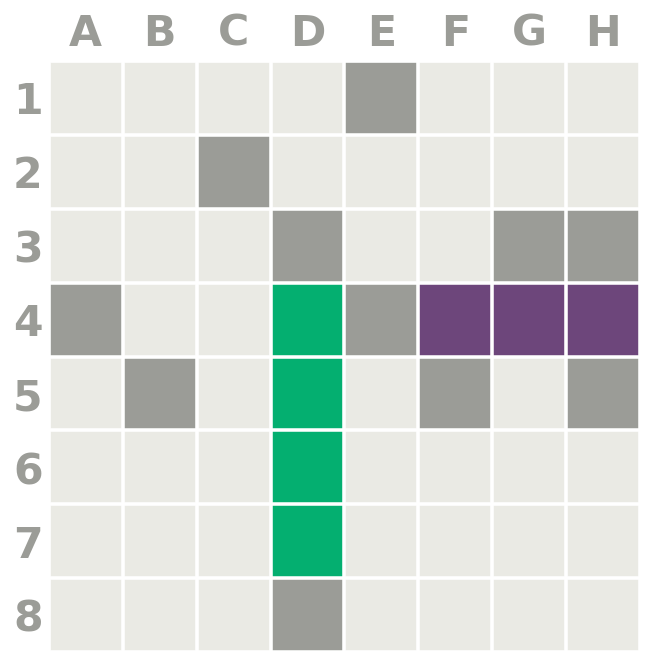

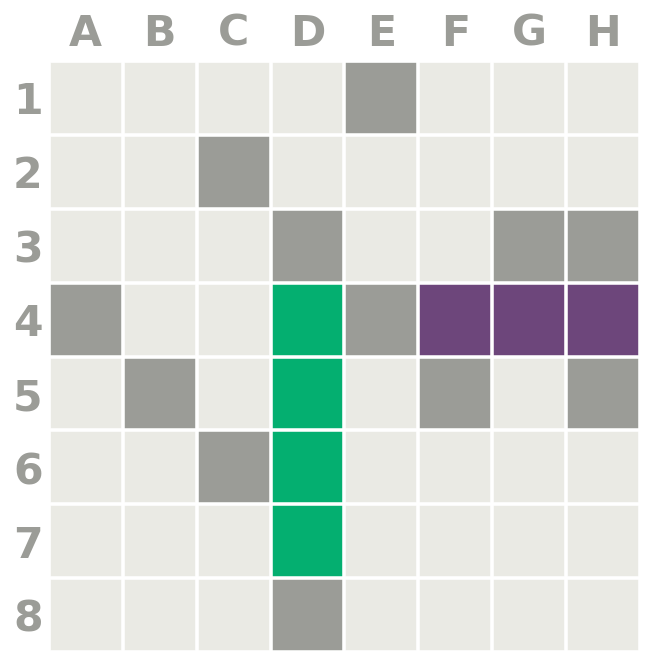

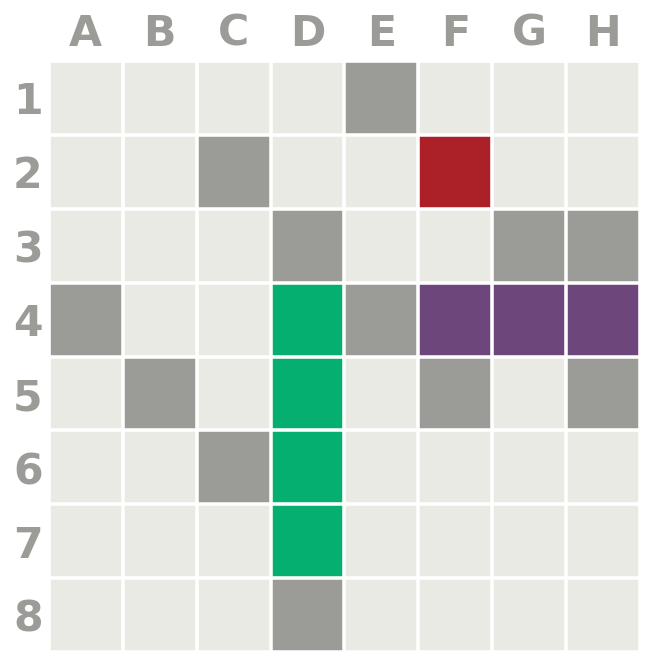

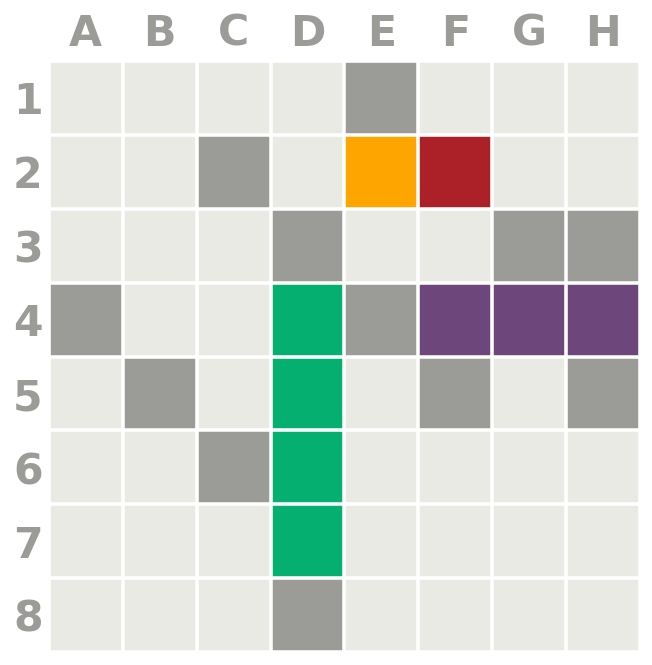

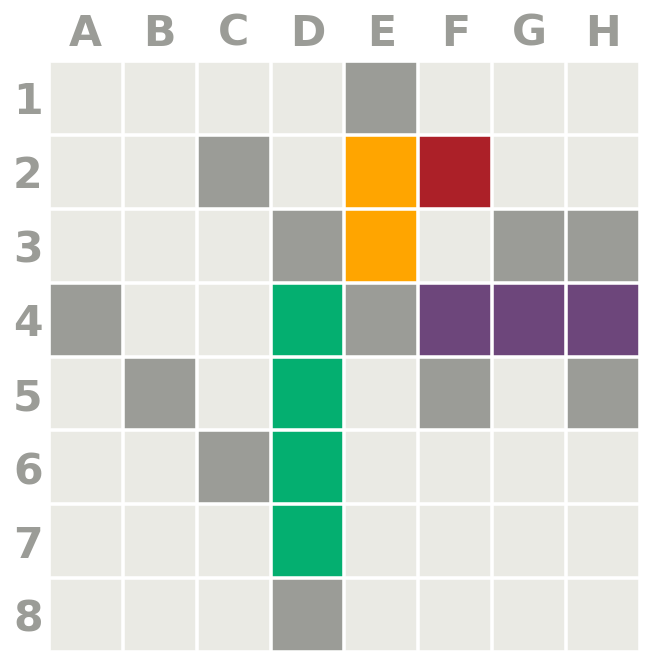

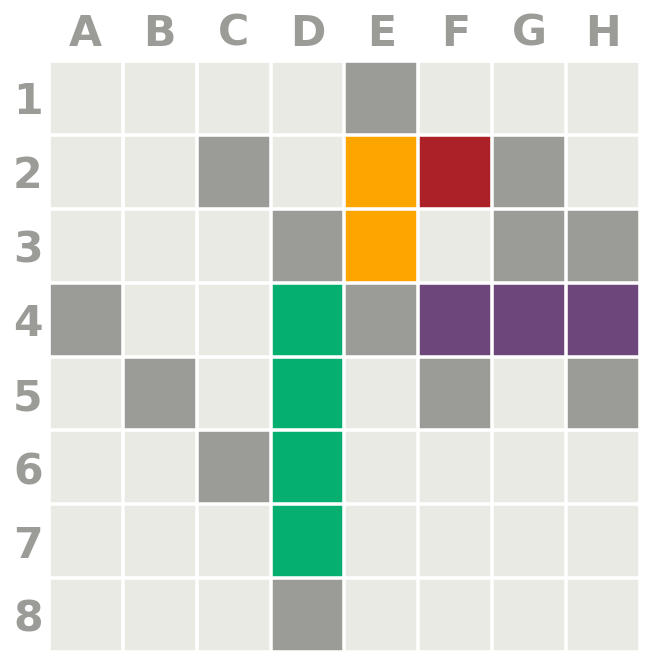

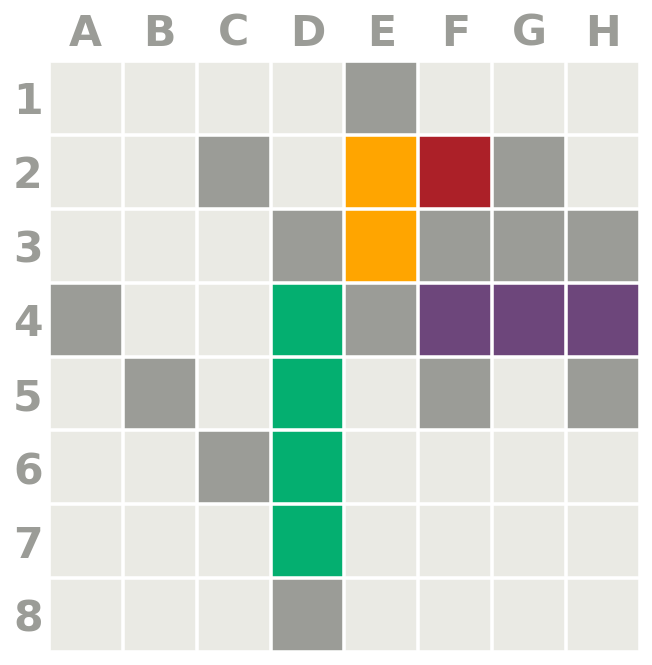

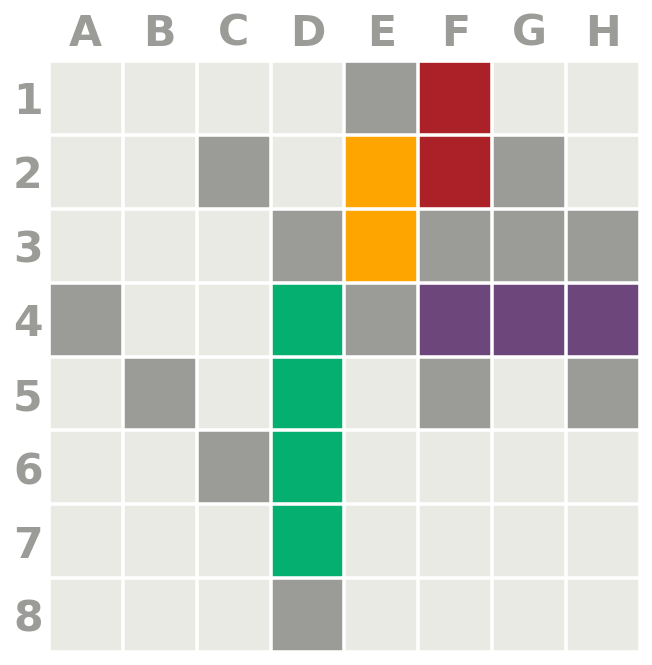

Finished in 25 moves!


In [33]:
moves = simulate_game(BOARD_EMPTY, BOARD_TARGET, seed=SEED, show_board=True)

In [46]:
# Compute the distribution of the number of moves required to finish the game for different boards and sample sizes

SEED_GENERATOR = 123
SEED_SIMULATOR = 456
N_BOARDS = 100
N_SAMPLES = [10, 100, 1000]

sampler = FastSampler(
    board=BOARD_EMPTY,
    ship_lengths=SHIP_LENGTHS,
    ship_labels=SHIP_LABELS,
    seed=SEED_GENERATOR,
)

# Generate test boards
print(f"Generating {N_BOARDS} target boards...")
target_boards = []
for _ in range(N_BOARDS):
    board_target = sampler.populate_board()
    target_boards.append(board_target)

# Simulate games
print(f"Simulating games...")
results = []
for n_samples in N_SAMPLES:
    print(f"n_samples={n_samples}")
    for board_id, target_board in tqdm(enumerate(target_boards), total=len(target_boards)):
        moves = simulate_game(
            BOARD_EMPTY, target_board, n_samples=n_samples, seed=SEED_SIMULATOR
        )
        results.append(
            {
                "board_id": board_id,
                "n_samples": n_samples,
                "n_moves": len(moves),
            }
        )

Generating 100 target boards...
Simulating games...
n_samples=10


 48%|████▊     | 48/100 [00:02<00:02, 21.59it/s]

100%|██████████| 100/100 [00:04<00:00, 21.68it/s]


n_samples=100


100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


n_samples=1000


100%|██████████| 100/100 [02:37<00:00,  1.57s/it]


In [64]:
# Compute the mean of each distribution
results_df = pd.DataFrame(results)
results_mean = results_df.groupby("n_samples")["n_moves"].mean()
print(results_mean)

n_samples
10      40.00
100     33.31
1000    31.86
Name: n_moves, dtype: float64


<Axes: xlabel='n_moves', ylabel='Probability'>

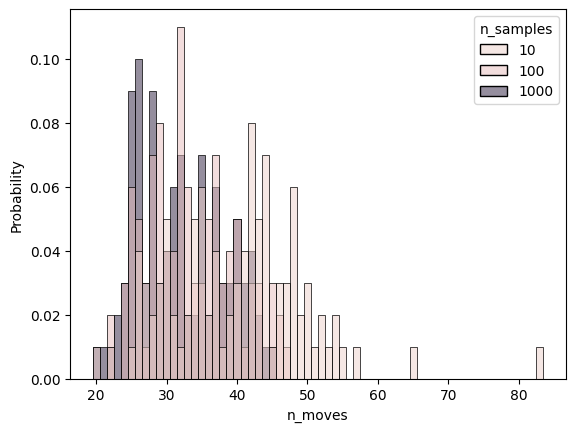

In [48]:
# using seaborn
sns.histplot(data=pd.DataFrame(results), x="n_moves", hue="n_samples", discrete=True, stat="probability", common_norm=False)

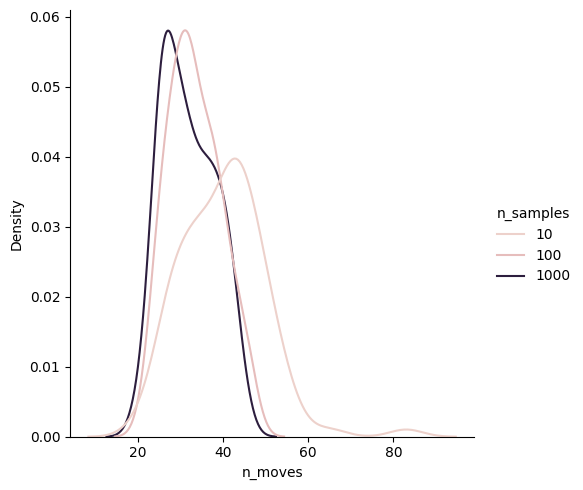

In [54]:
# kde plot
sns.displot(data=pd.DataFrame(results), x="n_moves", hue="n_samples", kind="kde", common_norm=False)

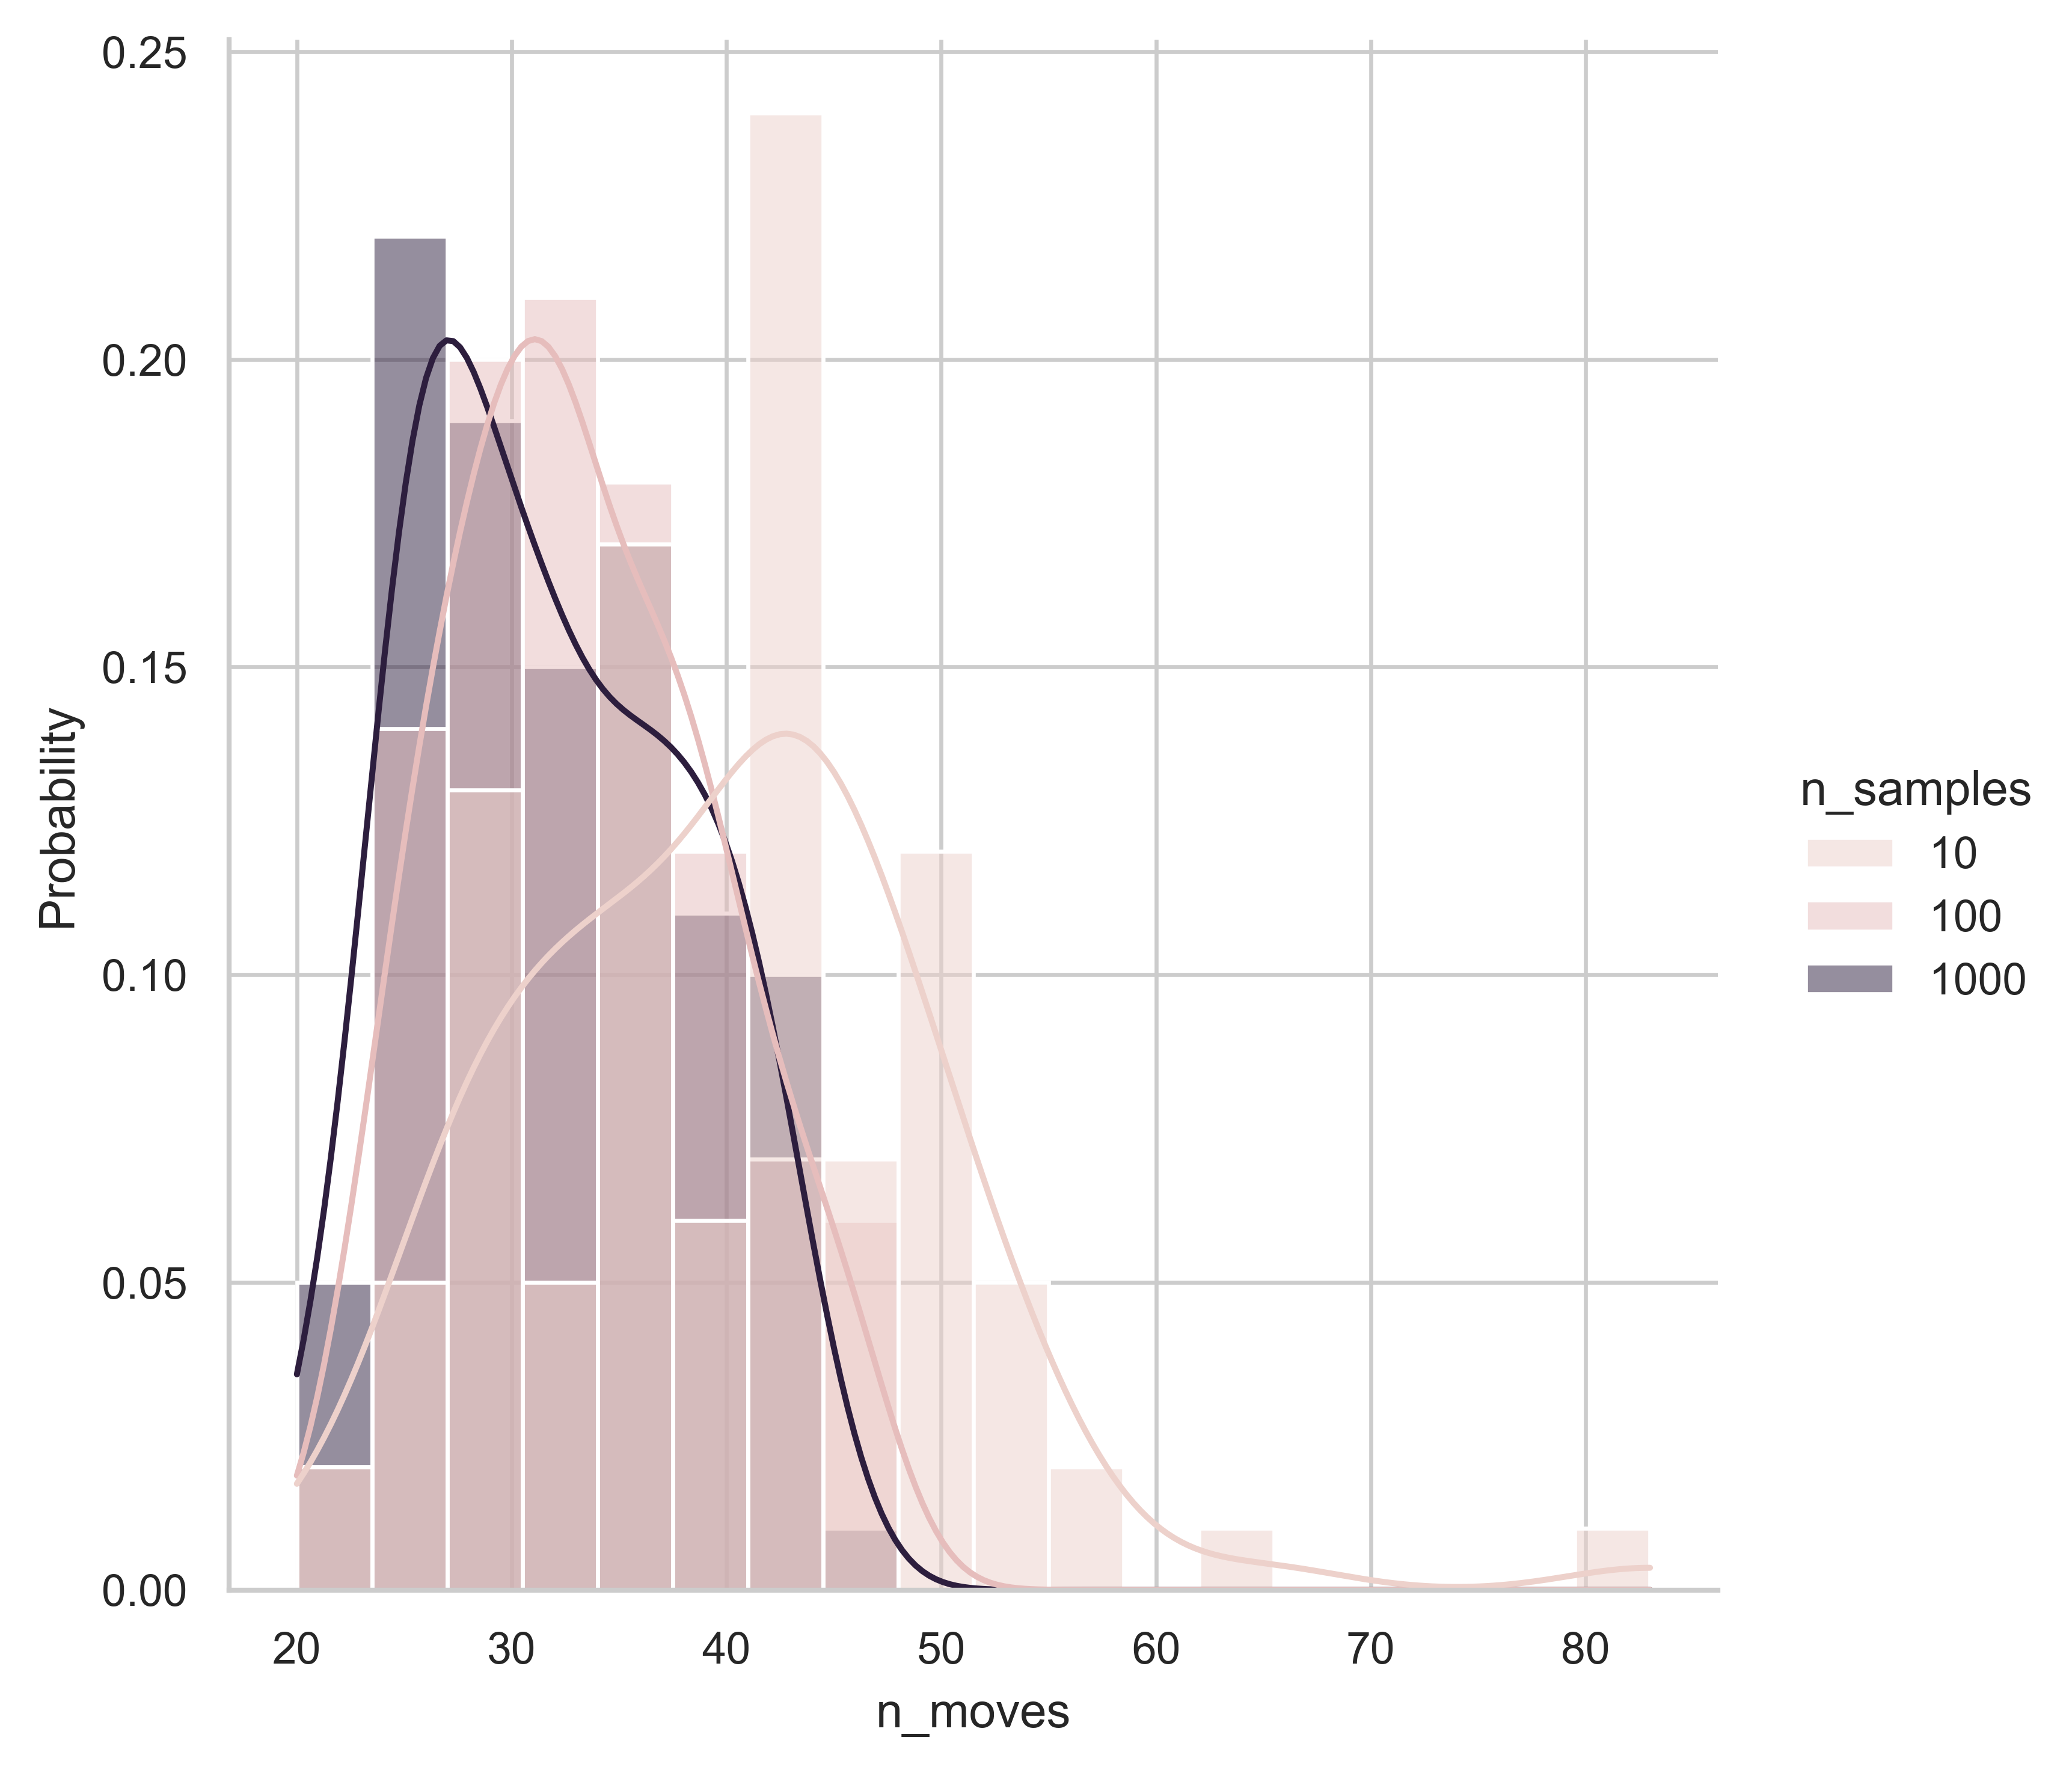

In [62]:
# combined histogram and kde
sns.displot(data=pd.DataFrame(results), x="n_moves", hue="n_samples", kind="hist", stat="probability", common_norm=False, kde=True)